In [874]:
#!pip3 install cartopy
#!pip3 install pycountry_covert
#import pycountry_convert as pc
#!pip install import wget
import cartopy.crs as ccrs
import re
import os
import requests
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import urllib
import geopandas as gpd
import geopandas as gpd
from zipfile import ZipFile
from shapely.geometry import Point
import matplotlib.pyplot as plt
import fiona


In [884]:
# a function to get all the ISO3 coundtry codes from wikipedia

def getISO3code(country = None, table = None):
    
    link = "https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3"
    session = urlopen(link)
    read_page = session.read().decode("utf-8")

    soup = BeautifulSoup(read_page, "html.parser")


    station_name_tag = soup.find_all("h4")

    
    ISO_3 = soup.find_all("span", class_="monospaced")

    full_name = soup.find_all('a', title=True)


    ISO_3_code =[]

    names = []


    # get ISO codes

    for i in ISO_3:
        for child in i.descendants:
            ISO_3_code.append(child)
    
    #The data starts with Aruba nd ends with Zimbabwe
    for i in range(len(ISO_3_code)):

        if ISO_3_code[i] == "ABW":

            start_ISO = i

        elif ISO_3_code[i] == "ZWE":

            end_ISO = i       

    ISO3_complete = ISO_3_code[start_ISO:end_ISO+1]

   
    # Get the full names corresponding to each code
    
    for name in full_name:

        for child in name.descendants:

            names.append(child)


        
 # grab start and end of country names       


    for i in range(len(names)):
        if names[i] == "Aruba":
            start_name = i
        elif names[i] == "Zimbabwe":
            end_name =i
            
    fullNames = names[start_name:end_name+1]
    fullNames.remove('Province of China')
    
    data = pd.DataFrame(
    {'Country_name': fullNames,  'ISO3_Code':ISO3_complete}
    )
    
    if country:
        if table:
            return data[data.Country_name==country]
        else:
            return str(data[data.Country_name==country].iloc[0,1])
    else:
        return data

    
    

In [885]:

getISO3code("Saudi Arabia")

'SAU'

##### Available formats

- The ***"geopackage"*** format is the a very good general spatial data file format (for vector data). It is based on the SpatiaLite format, and can be read by software using GDAL/OGR, including R (with the 'sf' package), QGIS and ArcGIS you can specify this package like this (*file_format = 'gpkg'*).

- A ***"shapefile"*** consist of at least four actual files (.shp, .shx, .dbf, .prj). This is an obsolete, but still commonly used format that can be directly used in a lot of software such as ArcGIS and DIVA-GIS, and many other programs(*file_format = 'shp'*).

- "R sp" and "sf ***(.rds)*** and ***(.kmz)*** formats have not been implemented

- To be implemented: the natural earth level 0 country boundaries for the entire world.

In [886]:

# retrieves the FAO GADM boundary data, level 3. the code is based on version 3.6 of the data

def getGADMdata(country = None, level= None, file_format = None):
    current_dir = os.getcwd()
    
    base_url = "https://biogeo.ucdavis.edu/data/gadm3.6/"
    
    if country:
        file_name = f'{country}_level3_Admin.zip'

        file_path = current_dir + "/" + file_name

        
        roi = getISO3code(f'{country}')
        link = base_url + str(file_format) + "/" +"gadm36_" + roi + "_" + str(file_format) +".zip"
        link = re.sub("None", "", link)
        
        print(f"downloading {file_name} data from {link}")
        
    
            
        if file_format == "shp":
            
                if os.path.exists(file_path):
                    # Unzip the downloaded file and read it inton python

                    with ZipFile(file_path, 'r') as zipObj:
                        # Extract all the contents of zip file in current directory
                        zipObj.extractall()
                    
                    file_path = f'{current_dir}/gadm36_{roi}_{level}.{file_format}'
                    file_path = re.sub("None", "", file_path)
                    gpd_df = gpd.read_file(file_path)
                #return gpd_df[gpd_df.NAME_0 == country]
                else:
                    print(f"downloading data from {link}")
                
                    urllib.request.urlretrieve(link, file_path)
                    # Unzip the downloaded file and read it inton python
                    
                    with ZipFile(file_path, 'r') as zipObj:

                        # Extract all the contents of zip file in current directory
                        zipObj.extractall()
                    
                    file_path = f'{current_dir}/gadm36_{roi}_{level}.{file_format}'
                    file_path = re.sub("None", "", file_path)
                
                    gpd_df = gpd.read_file(file_path)
                    #gpd_df = gpd_df[gpd_df.NAME_0 == country]
        
        else: 
            if os.path.exists(file_path):
                file_path = f'{current_dir}/gadm36_{roi}.{file_format}'
                file_path = re.sub("None", "", file_path)
                gpd_df = gpd.read_file(file_path)
            else:
                print(f"downloading data from {link}")
                
                urllib.request.urlretrieve(link, file_path)
                file_path = f'{current_dir}/gadm36_{roi}.{file_format}'
                file_path = re.sub("None", "", file_path)
                gpd_df = gpd.read_file(file_path)
                
    return gpd_df
        
        
   

downloading Saudi Arabia_level3_Admin.zip data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_SAU_shp.zip


<AxesSubplot:>

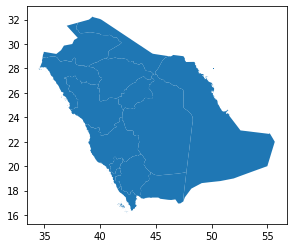

In [887]:
# Implementation 
oman = getGADMdata(country = "Saudi Arabia", file_format = "shp", level = "1")
oman.plot()

In [894]:

csv_data = pd.read_csv("../Decrypted/DL_Treatment_data_More_precise_Location2.csv")

#csv_data[csv_data.Country == "ARABIA"] = "SAUDI ARABIA"


csv_data = csv_data.replace("ARABIA","SAUDI ARABIA")




# group the data by the country colum and compute the sum
country_sum = csv_data.groupby(["Country"],as_index = False).sum()

# Capitalize the country names to match the naming in the global data
# drop the year information
country_sum["Country"] = country_sum["Country"].str.title()
country_sum = country_sum.drop(["Year"],axis=1)

#change the country name column to match the naming on the global dataset
country_sum = country_sum.rename(columns = {'Country': "SOVEREIGNT"})
country_sum

,SOVEREIGNT,T_area (ha)
0,Afghanistan,2969
1,Algeria,1435
2,Djibouti,65
3,Egypt,22514
4,Eritrea,117607
5,Ethiopia,1437105
6,India,639150
7,Iran,1017206
8,Iraq,2750
9,Jordan,4700


In [896]:
# load level 0 country plot and join it with the country_sum based on the SOVEREIGNT column

world_leve0_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

world_leve0 = gpd. read_file(world_leve0_path)
#world_leve0.plot()

world_level_0_country_sum_joined = world_leve0.join(country_sum.set_index('SOVEREIGNT'), on='SOVEREIGNT')
world_level_0_country_sum_joined

world_level_0_country_sum_joined#.plot()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,T_area (ha)
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",NaN
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",NaN
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",NaN
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",NaN
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",NaN
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,None,None,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4...",NaN
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796...",NaN
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,Serranilla Bank,SER,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864...",NaN


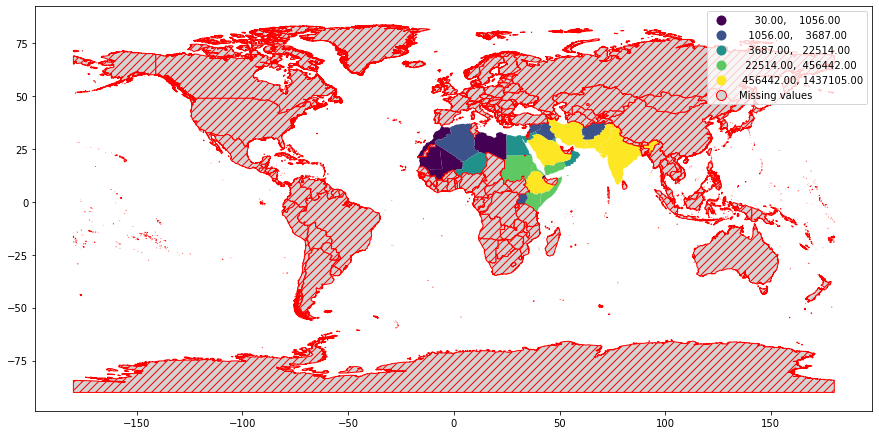

In [899]:
world_level_0_country_sum_joined.plot(
    column="T_area (ha)",
    legend=True,
    scheme="quantiles",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);


#### Make point_vector data from all the collected location information
- In the csv_data that was previously loaded, there are the columns all_Nothing and all_Eastings which contain all the northings and Eastings available from FAO for each month and for each country.This information is stored as a list for each month (each month could have multiple locations mentioned). The goal of the code below is to extract each point and convert it into a proper geolocation (geopandas point dataframe) for visualization.

In [900]:
# Read the csv file and grab all the location data in the columns: all_Nothings and all_Easting and convert them
# to point vector data
#csv_data = pd.read_csv("../Decrypted/DL_Treatment_data_More_precise_Location2.csv")
#csv_data

lat = []
lon = []
countries = []
months = []
Years =[]

for i in range(csv_data.shape[0]):
    year = csv_data.loc[i][0]
    month = csv_data.loc[i][1]
    country = csv_data.loc[i][2]
    
    
    all_North_monthly = csv_data.loc[i][3] 
    all_East_monthly = csv_data.loc[i][4] 
    
    
     
    points_lat = re.findall(r"[A-Z0-9]+",all_North_monthly) # just get the numbers and do not keep N/S this is becauswe all countries of interest are all in ther northern hemisphere
    points_lon = re.findall(r"[A-Z0-9]+",all_East_monthly) # keep the East/West information as some countries lie in the west of greenwitch. the coordinates will be assined to negative in that case
    
    
    for location_lat,location_lon  in zip(points_lat,points_lon):
        if country == "ARABIA":
            countries.append("SAUDI ARABIA")
        else:
            countries.append(country)
            
        months.append(month)
        Years.append(year)
        
        #y_coord = float(location_lat[0:2] + "." + location_lat[2:4])
        #lat.append(y_coord)
        
        # check if the location in the west of GWM and assign -ve value else leave it as it is and only insert point.
        
        if location_lon[-1] == "W":
            x_coord = location_lon[0:-1]
            x_coord = float("-" + x_coord[0:2] + "." + x_coord[2:4])
            lon.append(x_coord)
        else:
            x_coord = location_lon[0:-1]
            x_coord = float(x_coord[0:2] + "." + x_coord[2:4])
            lon.append(x_coord)
        
        if location_lat[-1] == "S":
            x_coord1 = location_lat[0:-1]
            x_coord1 = float("-" + x_coord1[0:2] + "." + x_coord1[2:4])
            lat.append(x_coord1)
        else:
            x_coord1 = location_lat[0:-1]
            x_coord1 = float(x_coord1[0:2] + "." + x_coord1[2:4])
            lat.append(x_coord1)
            
        
        
point_vector_data = pd.DataFrame(
   {'Year': Years, 'Month': months, 'Country': countries, 'Lat': lat, 'Lon': lon}
)
point_vector_data

,Year,Month,Country,Lat,Lon
0,2019,Mar,SUDAN,17.45,38.20
1,2019,Mar,SUDAN,20.34,37.02
2,2019,Mar,ERITREA,15.37,39.28
3,2019,Mar,ERITREA,16.28,38.56
4,2019,Mar,ERITREA,17.23,38.33
...,...,...,...,...,...
1333,2019,Aug,INDIA,25.43,71.25
1334,2019,Aug,INDIA,26.52,70.55
1335,2019,Aug,INDIA,27.06,72.22
1336,2019,Aug,INDIA,28.01,73.22


In [901]:
# Covert the above created point data into geopanda dataframe

geometry = [Point(xy) for xy in zip(point_vector_data.Lon, point_vector_data.Lat)]

# drop the lon lat columns
df = point_vector_data.drop(['Lon', 'Lat'], axis=1)

gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

#gdf = gdf.drop(["all_Northing", "all_Easting"], axis=1)
gdf

,Year,Month,Country,geometry
0,2019,Mar,SUDAN,POINT (38.20000 17.45000)
1,2019,Mar,SUDAN,POINT (37.02000 20.34000)
2,2019,Mar,ERITREA,POINT (39.28000 15.37000)
3,2019,Mar,ERITREA,POINT (38.56000 16.28000)
4,2019,Mar,ERITREA,POINT (38.33000 17.23000)
...,...,...,...,...
1333,2019,Aug,INDIA,POINT (71.25000 25.43000)
1334,2019,Aug,INDIA,POINT (70.55000 26.52000)
1335,2019,Aug,INDIA,POINT (72.22000 27.06000)
1336,2019,Aug,INDIA,POINT (73.22000 28.01000)


(-9.120000000000001, 40.55)

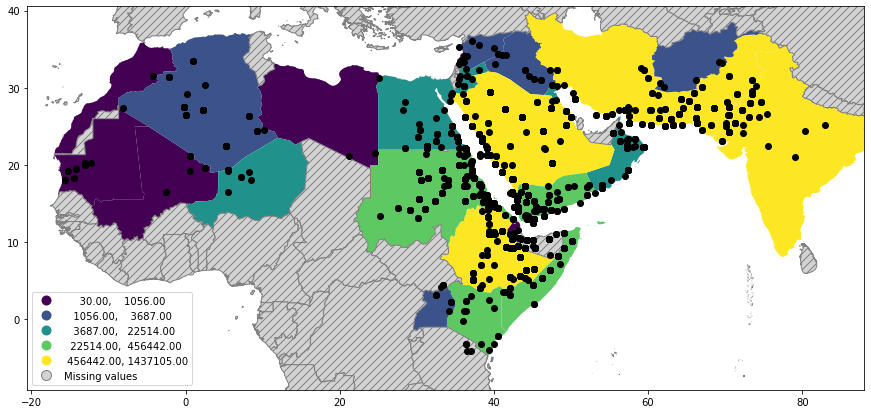

In [929]:
minx, miny, maxx, maxy = gdf.total_bounds



ax = gdf.plot(figsize=(15,10),color='k', zorder=2,legend=True)
world_level_0_country_sum_joined.plot(ax=ax,
                                     zorder =1,
                                     column="T_area (ha)",
                                     legend=True,
                                     scheme="quantiles",
                                      missing_kwds={
                                          "color": "lightgrey",
                                          "edgecolor": "grey",
                                          "hatch": "///",
                                          "label": "Missing values",},
                                     )
ax.set_xlim(minx-5, maxx +5)
ax.set_ylim(miny-5, maxy-30)

In [914]:
# Make a function to plot specific country

def countryPlot(country):
    #points = gdf[gdf.Country == country.upper()]
    
    polygon = getGADMdata(country = country, file_format = "shp", level = "1")
    
    points = gpd.clip(gdf, polygon)
    
    fig, ax = plt.subplots(figsize=(20,15))
    #print(country)
    #color='k', zorder=2
    
    
    polygon.plot(ax=ax, 
         facecolor='lightgrey',
         edgecolor='k',
         #color='k', 
         zorder=1,
         alpha=1,
         linewidth=1,
         #cmap="cividis",
         missing_kwds={
             "color": "lightgrey",
             "edgecolor": "grey",
             #"hatch": "///",
             "label": "Missing values",
         })
    points.plot(ax=ax,
                zorder=3,
                column='Year', 
                markersize=70, 
                cmap='viridis',
                categorical=True,
               legend=True,
                legend_kwds={'fontsize':16,'frameon':False});
    #print(points)

downloading Pakistan_level3_Admin.zip data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_PAK_shp.zip


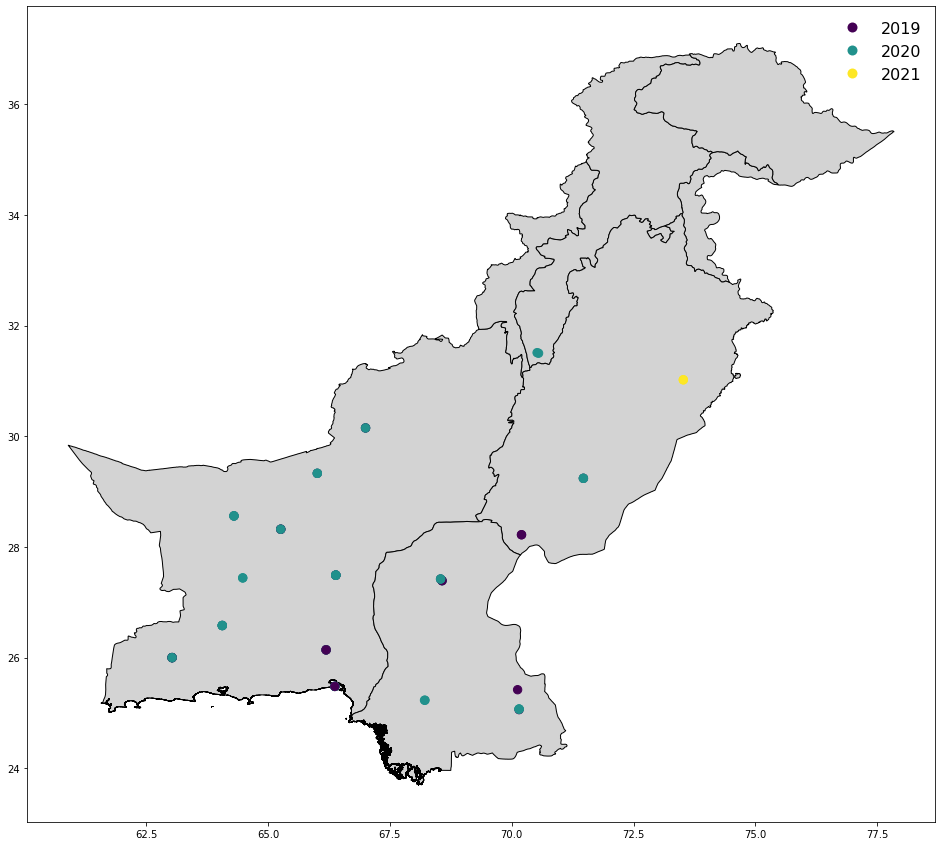

In [915]:
countryPlot("Pakistan")

downloading Kenya_level3_Admin.zip data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_KEN_shp.zip


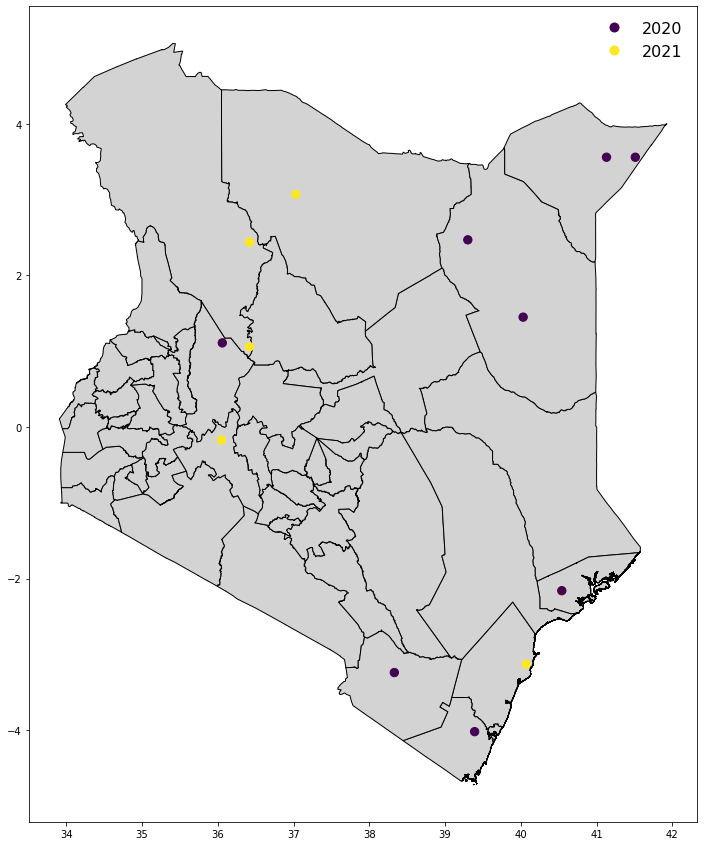

In [819]:
countryPlot("Kenya")

downloading Ethiopia_level3_Admin.zip data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_ETH_shp.zip


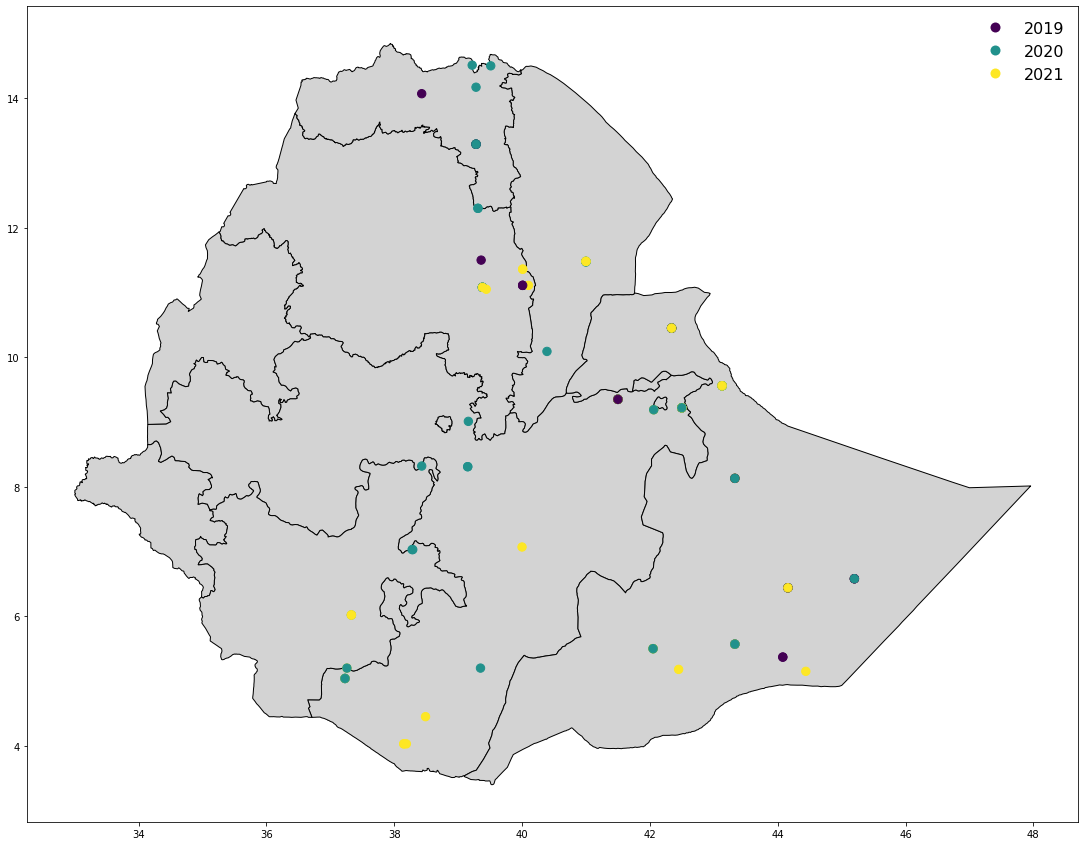

In [820]:
countryPlot("Ethiopia")

downloading India_level3_Admin.zip data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip


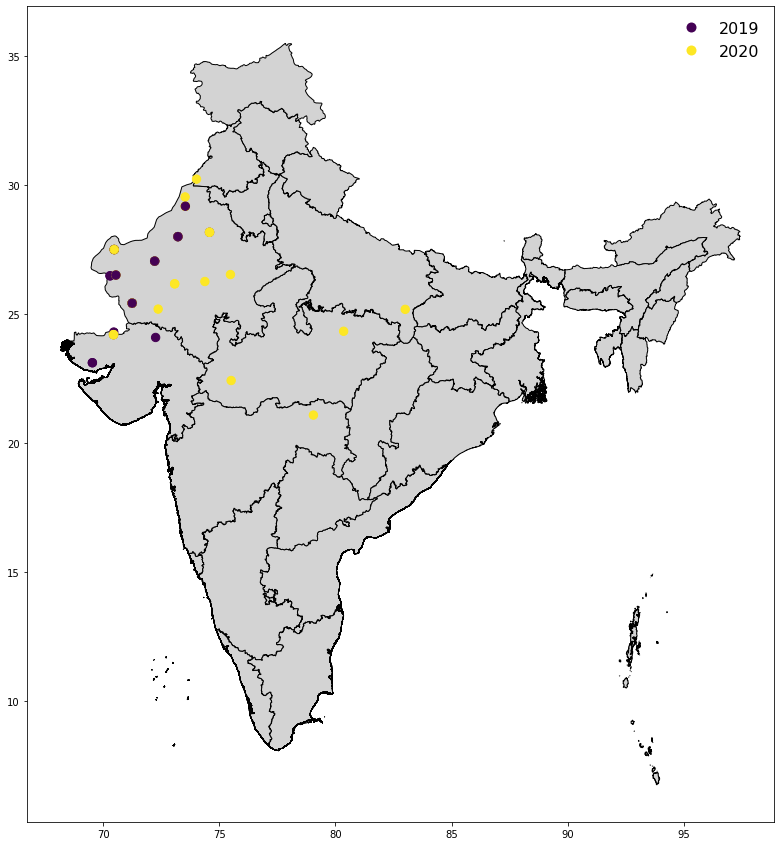

In [821]:
countryPlot("India")

In [822]:

# function to check for unique values in a list



def unique(list_):
    unique_list = []
    for item in list_:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list
            

downloading Saudi Arabia_level3_Admin.zip data from https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_SAU_shp.zip


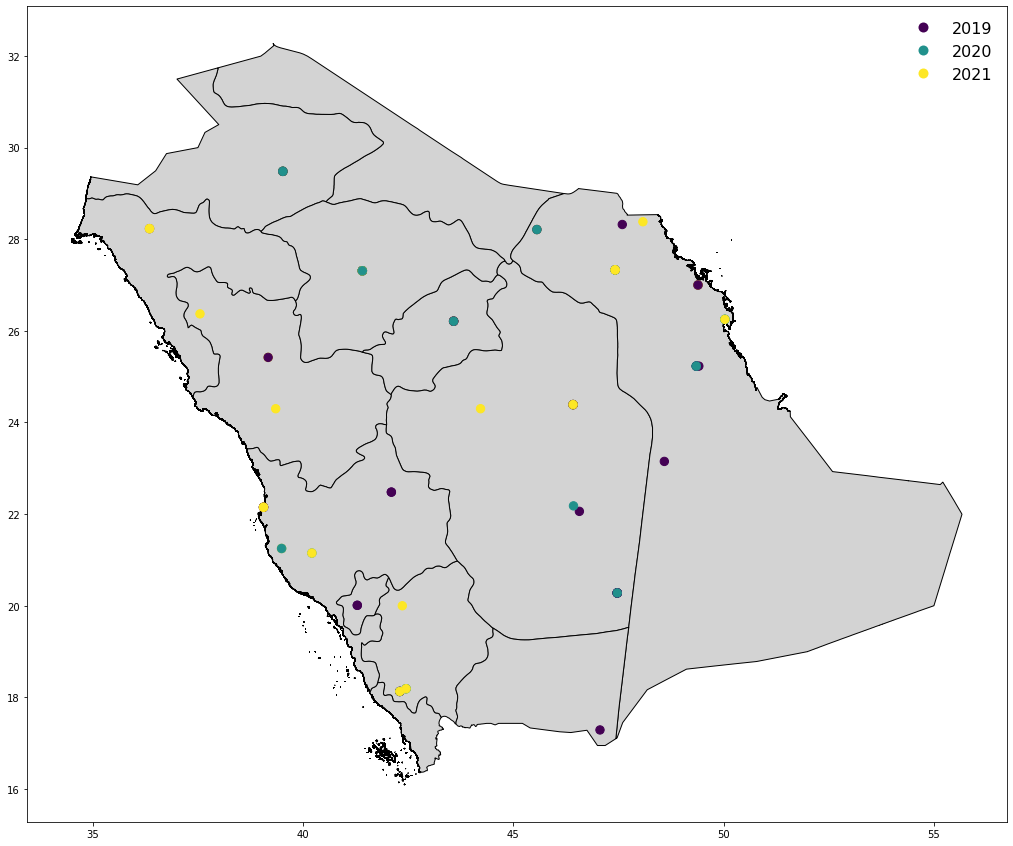

In [831]:
countryPlot("Saudi Arabia")

In [937]:
unique(country_sum.SOVEREIGNT)

['Afghanistan',
 'Algeria',
 'Djibouti',
 'Egypt',
 'Eritrea',
 'Ethiopia',
 'India',
 'Iran',
 'Iraq',
 'Jordan',
 'Kenya',
 'Kuwait',
 'Lebanon',
 'Libya',
 'Mali',
 'Mauritania',
 'Morocco',
 'Niger',
 'Oman',
 'Pakistan',
 'Saudi Arabia',
 'Somalia',
 'Sudan',
 'Syria',
 'Tanzania',
 'Uganda',
 'Yemen']